In [13]:
import pandas as pd
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from scipy.spatial.distance import cdist 
from sklearn import metrics
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/inochka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/inochka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/inochka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/inochka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# import dataset
thread_name = 'AmItheAsshole'
posts_num = 27920

posts_df = pd.read_csv( f'{thread_name}_latest_{posts_num}_posts.csv' )
posts_df.date = pd.to_datetime(posts_df.date, format='%d-%m-%Y')
posts_df.head()

,title,text,date,num_upvotes,num_comments,id,first_comment,first_comment_upvotes
0,AITA for calling out a bestfriend for ruining ...,My ex bestfriend is upset and calling me being...,2023-04-01,NaN,1,128fs8w,NTA- I guess she didn't like hearing the trut...,NaN
1,AITA for telling my Friend her Mother looks li...,I'll try to keep this short (please ignore gra...,2023-04-01,NaN,1,128frit,It's one thing to mix things up! It's another ...,NaN
2,AITA for singing at my friend's wedding?,I (24F) was a bridesmaid in my friend's (25F) ...,2023-04-01,NaN,1,128fpih,"NTA. Where I’m from, this sort of thing happen...",NaN
3,AITA for using outdated terminology to describ...,"I have autism, but it was classified as asperg...",2023-04-01,NaN,1,128flwe,NTA. I still identify with the term. But I've ...,NaN
4,WIBTA if I would sue my parents for animal abuse?,"Hello, throwaway for obvious reasons.\n\nI (18...",2023-04-01,NaN,1,128fl9c,It would definitely be blowing everything way ...,NaN


In [8]:
# update texblob vocabulary with common words in the thread:

import textblob as tb

custom_words = ['mil', 'sil', 'bil', 'ex', 'exbf', 'exgf','fil','bf','gf','mom']

for word in custom_words:
    tb.en.spelling.update({word:1})

# cleaning titles
posts_df['title_clean'] = posts_df.title
# removing digits, punctuation, setting lower case 
posts_df['title_clean'] = posts_df['title_clean'].str.replace(r'[^\w\s]|\d+','').str.lower()
# removing introductory words (AITA for or WIBTA):
posts_df['title_clean'] = posts_df['title_clean'].str.replace('aita','').str.replace('wibta','').str.replace('for','')
# spelling correction:
posts_df['title_clean'] = posts_df['title_clean'].apply( lambda z: str(TextBlob(z).correct()) )

# save cleaned df down 
posts_df['title_clean'].to_csv(f'{thread_name}_latest_{posts_num}_posts_clean_titles.csv')


In [9]:
# title processing function:
def text_correction(text):
    # Tokenize the title into words
    words = nltk.word_tokenize(text)
    
    # Get only verbs and nouns
    # Remove stop words.
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()

    stop_words = set(stopwords.words('english'))
    tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos='v') for word, tag in tags if (tag.startswith('V') or tag.startswith('N')) \
                                                                            and word not in stop_words]
    
    return ' '.join(words)

# Examplary text data
texts = posts_df.title_clean.sample(n=1, random_state=101)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=text_correction)

# Fit and transform text data
X = vectorizer.fit_transform(texts)

# Get feature names (words)
feature_names = vectorizer.get_feature_names()

# Print feature names
print(texts.values)
print(feature_names)

['  not really liking my finances kiss']
['finance', 'kiss', 'like']


In [10]:
# vectorise clean titles array
vectorizer = TfidfVectorizer( preprocessor=text_correction )
X = vectorizer.fit_transform(posts_df.title_clean.values)
X.shape

(27920, 5621)

In [11]:
# some fuatured words:
vectorizer.get_feature_names()

['aback',
 'abandon',
 'abduct',
 'abduction',
 'abide',
 'ability',
 'ablest',
 'abort',
 'abortion',
 'absolute',
 'absorb',
 'abstract',
 'abuse',
 'abusive',
 'abusiveboyfriend',
 'ac',
 'acapella',
 'accent',
 'accept',
 'acceptance',
 'acceptdeny',
 'access',
 'accident',
 'accidents',
 'accommodate',
 'accommodation',
 'accommodations',
 'accompany',
 'accomplishment',
 'accord',
 'account',
 'accountability',
 'accountable',
 'accumulate',
 'accusation',
 'accusations',
 'accuse',
 'ache',
 'achieve',
 'achievement',
 'achievements',
 'acid',
 'acknowledge',
 'acknowledgment',
 'acne',
 'acquaint',
 'acquaintance',
 'acquaintances',
 'across',
 'act',
 'action',
 'activist',
 'activities',
 'activity',
 'actor',
 'actress',
 'ad',
 'adapt',
 'add',
 'adderall',
 'addict',
 'addition',
 'address',
 'adduct',
 'adhere',
 'adjust',
 'administrator',
 'administrators',
 'admirer',
 'admission',
 'admit',
 'adopt',
 'adoption',
 'adult',
 'adults',
 'advance',
 'advantage',
 'advent

In [14]:
# run PCA to reduce dimensions before clustering 

pca = PCA( n_components = 0.95, random_state = 101)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(27920, 2648)

### K-Mean clustering of titles

k=5, silhouette score=0.015396129882661766, inertia=25401.819603365217
k=6, silhouette score=0.015341432744072164, inertia=25258.001773025422
k=7, silhouette score=0.018072985036160914, inertia=25104.141981999237
k=8, silhouette score=0.019573285945570253, inertia=25028.004839763045
k=9, silhouette score=0.020121471160008876, inertia=24966.929201668372
k=10, silhouette score=0.021126380749270732, inertia=24865.176343021627
k=11, silhouette score=0.02297954111423276, inertia=24733.22380227421
k=12, silhouette score=0.023056372414333174, inertia=24617.05369639144
k=13, silhouette score=0.027089848867744792, inertia=24545.513834316647
k=14, silhouette score=0.024429857739238656, inertia=24505.19349556852
k=15, silhouette score=0.021758336576029037, inertia=24546.846132777977
k=16, silhouette score=0.025434285963014433, inertia=24549.206853634303
k=17, silhouette score=0.027100024530349192, inertia=24357.103429376824
k=18, silhouette score=0.02889672551054577, inertia=24318.349336903455
k=

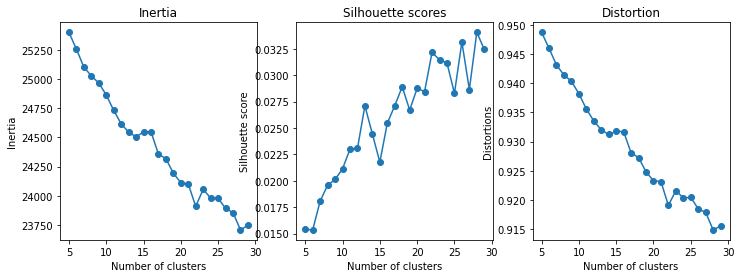

In [15]:
# create a list to store the scores for different k values
silhouette_scores = []
inertias = []
distortions = []

cluster_range = range(5, 30)

# search through k values from 5 to 30
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(X_reduced)
    # calculate metrics
    inertias.append(kmeans.inertia_)
    score = metrics.silhouette_score(X_reduced, kmeans.labels_)
    silhouette_scores.append(score)
    distortion = sum(np.min(cdist(X_reduced, kmeans.cluster_centers_,'euclidean'),axis=1))/X_reduced.shape[0]
    distortions.append( distortion )
    print(f"k={k}, silhouette score={score}, inertia={kmeans.inertia_}")
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Plot the inertias
ax1.plot(cluster_range, inertias, '-o')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Inertia')
# Plot the silhouette scores
ax2.plot(cluster_range, silhouette_scores, '-o')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette scores')
# Plot the distortions
ax3.plot(cluster_range, distortions, '-o')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Distortions')
ax3.set_title('Distortion')

plt.show()

In [16]:
k = 14
kmeans = KMeans(n_clusters = k, random_state=42)
kmeans.fit(X_reduced)

# Add the cluster labels to the dataframe
posts_df['kmean_cluster'] = kmeans.labels_

# Get the counts for each cluster
counts = posts_df['kmean_cluster'].value_counts()

# Get the two most popular clusters
top_clusters = counts.index.tolist()

# sort clusters by popularity
print("Most polular classes (by average number of upvotes): ")
posts_df['num_upvotes'].groupby(posts_df.kmean_cluster).mean().sort_values(ascending=False)

Most polular classes (by average number of upvotes): 


kmean_cluster
7     858.899329
10    496.617922
3     454.730216
0     418.566929
4     402.316894
9     377.400621
1     299.133092
6     272.773973
13    197.328302
8     189.831399
2     187.476684
11    182.531419
12    158.635417
5     116.631778
Name: num_upvotes, dtype: float64

### Word Clouds 

Top words in titles. Cluster 7:


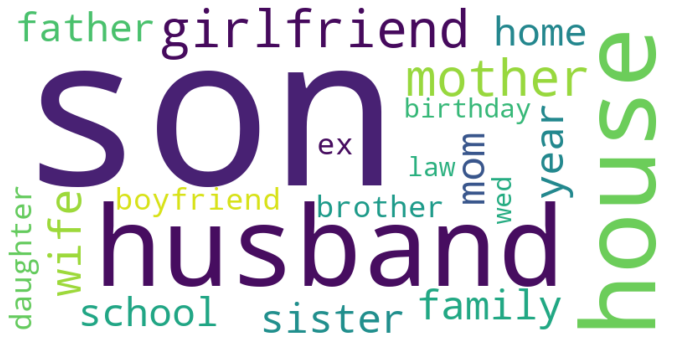

Top words in titles. Cluster 10:


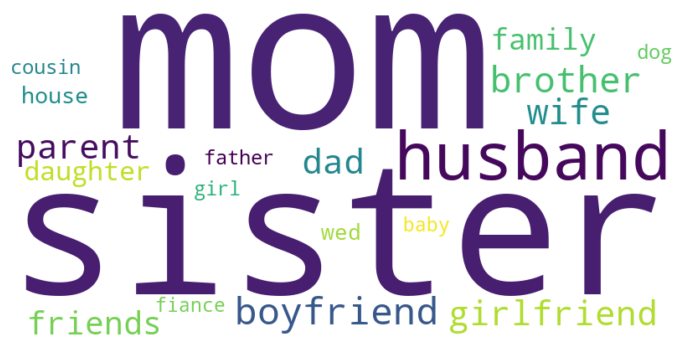

Top words in titles. Cluster 3:


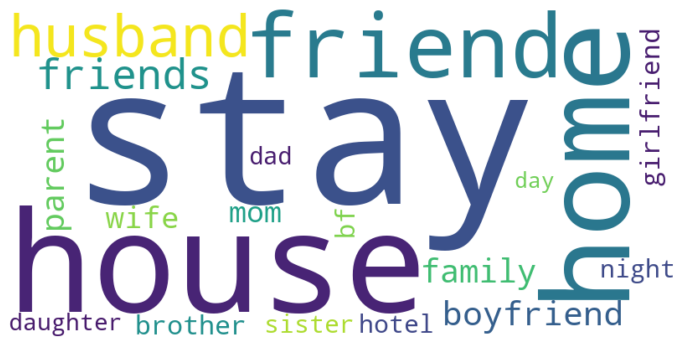

In [20]:
# text preprocessing function. Keep only Nouns:
def text_nouns(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # keep only nouns
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos='v') for word, tag in tags if ( tag.startswith('N') ) ]
    return ' '.join(words)

# Word Cloud drawer
def word_cloud_by_cluster( cluster_num, cluster_column):
    top_topics = posts_df[cluster_column == cluster_num ]['title_clean']
    # Draw a bag of words for the top two clusters
    top_topics_vectorizer = CountVectorizer(stop_words='english', preprocessor=text_nouns)
    top_1 = top_topics_vectorizer.fit_transform(top_topics)
    cluster_words = pd.DataFrame({'word': top_topics_vectorizer.get_feature_names(), 'counts': top_1.toarray().sum(axis=0)})
    cluster_words = cluster_words.sort_values(by='counts', ascending=False).head(20)
    print(f'Top words in titles. Cluster {cluster_num}:')
    # Convert dataframe to dictionary
    word_counts = dict(zip(cluster_words['word'], cluster_words['counts']))
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    # Display the generated image:
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

word_cloud_by_cluster( 7, posts_df.kmean_cluster )
word_cloud_by_cluster( 10, posts_df.kmean_cluster )
word_cloud_by_cluster( 3, posts_df.kmean_cluster )


## COMMENT GENERATOR TensorFlow

In [21]:
# Drop rows containing "AUTOMOD" in the "text" column
df_short = posts_df[ posts_df['first_comment'].str.contains('AUTOMOD') == False ]
# Keep only short posts, under 1000 signs
df_short = df_short[ posts_df.text.apply( lambda z: len(z)) <= 1000  ]

df_short.shape

(4768, 10)

In [55]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# Load the pre-trained model and tokenizer
model = TFGPT2LMHeadModel.from_pretrained('gpt2-medium')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

# Set the generation parameters
length = 100 # number of words in comment
temperature = 1.0

# Generate a comment
prompt = df_short.text.sample(n=1, random_state=102).str.replace('\n', ' ' ).values[0]
encoded_prompt = tokenizer.encode(prompt, return_tensors="tf")

# Generate text using the model
output_sequences = model.generate(input_ids = encoded_prompt, 
                                  max_length = len(encoded_prompt[0])+length*2, 
                                  min_length = len(encoded_prompt[0])+length,
                                  temperature = temperature,
                                  top_k = 50,
                                  top_p = 0.95,
                                  repetition_penalty = 0.8, 
                                  num_beams = 3,
                                  pad_token_id = tokenizer.eos_token_id, 
                                  length_penalty = 0.8, 
                                  no_repeat_ngram_size = 2,
                                  )

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [56]:
gpt2_comment = tokenizer.decode(output_sequences[0])

print(f"Original post: {prompt} \n")
print(f"Generated comment: {gpt2_comment.replace(prompt, '')}")

Original post: Long story short, we euthanized our childhood dog yesterday. Her organs were failing, diabetic, and on her last paw.  Not to mention, this all happened in my lap, as no other family member wanted to hold her during the process. Which I understand..  However, parents have come up with the brightest idea. They’re going to buy another dog of the same coloring, breed, even down to the same state we bought her in. And the cherry on top is that they’re going to give her the exact name as who we euthanized yesterday.  AITA for not supporting this idea? 

Generated comment:  

I'm not sure what to make of this, other than to say that I'm glad that my family is not the only ones who have decided to adopt a dog from a shelter. I think it's a great idea and I hope that other families will follow suit and adopt their own dogs from shelters, too. It's not always easy to find a good home for your dog, especially if you're a single parent with a young child, but it can be done. If you 

In [47]:
# save short df down for PyTorch
df_short.to_csv(f'{thread_name}_latest_{posts_num}_posts_short.csv')

____